## Задание
По имеющемуся датасету UTKFace необходимо построить две модели - модель предсказания пола и модель предсказания расы. 

За основу возьмем сеть, которая была обучена на датасете VGGFace2 для классификации лиц. Он содержит 3.3 миллиона изображений с 9000 разными персоналиями.

## Загрузка обученной модели

Сеть, которую мы будем дообучать мы возьмем из открытого источника: https://github.com/rcmalli/keras-vggface .

In [10]:
! pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-_q8jc83s
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-_q8jc83s
ERROR: Operation cancelled by user


In [11]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Пример использования модели можно найти в README у автора репозитория.

In [12]:
pip install keras_applications

In [13]:
from keras_vggface.vggface import VGGFace
vggface_model = VGGFace(model='resnet50') 

In [14]:
vggface_model.summary()

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_3[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_98 (Activation)      (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

Для проверки того, что помимо архитектуры мы правильно загрузили веса, проверим предсказания модели на следующем изображении: 

In [15]:
! wget https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg -O brad_pitt.jpg

--2021-07-26 13:54:40--  https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg
Resolving img.joinfo.ua (img.joinfo.ua)... 172.67.214.206, 104.21.83.52, 2606:4700:3035::ac43:d6ce, ...
Connecting to img.joinfo.ua (img.joinfo.ua)|172.67.214.206|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.joinfo.com/i/2019/01/5c4ea940d2b08.jpg [following]
--2021-07-26 13:54:40--  https://img.joinfo.com/i/2019/01/5c4ea940d2b08.jpg
Resolving img.joinfo.com (img.joinfo.com)... 172.67.153.243, 104.21.12.244, 2606:4700:3030::ac43:99f3, ...
Connecting to img.joinfo.com (img.joinfo.com)|172.67.153.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43154 (42K) [image/jpeg]
Saving to: ‘brad_pitt.jpg’

brad_pitt.jpg       100%[===================>]  42.14K  --.-KB/s    in 0.007s  

2021-07-26 13:54:41 (6.16 MB/s) - ‘brad_pitt.jpg’ saved [43154/43154]



После загрузки запустим полный пример из репозитория:

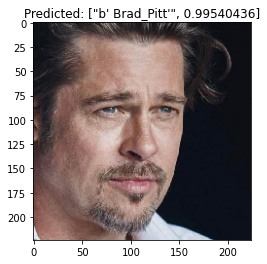

In [16]:
from keras_vggface import utils
from tensorflow.keras.preprocessing import image

img = image.load_img("brad_pitt.jpg", target_size=(224, 224)) # модель работает с картинками размера 224 на 224
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2) 

preds = vggface_model.predict(x)
plt.title(f"Predicted: {utils.decode_predictions(preds)[0][0]}")
plt.imshow(img)

## Загрузка данных


In [ ]:
from pathlib import Path
from collections import Counter

In [ ]:
url = 'https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk'
output = '/tmp/UTKFace.tar.gz'
gdown.download(url, output, quiet=False)
! tar -xzf /tmp/UTKFace.tar.gz -C /tmp/
url = 'https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2'
output = 'train_val_split_utk.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
To: /tmp/UTKFace.tar.gz
107MB [00:02, 49.7MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2
To: /content/train_val_split_utk.csv
100%|██████████| 1.08M/1.08M [00:00<00:00, 86.2MB/s]


'train_val_split_utk.csv'

In [ ]:
data_folder = Path("/tmp/UTKFace/")
filenames = list(map(lambda x: x.name, data_folder.glob('*.jpg')))
print(len(filenames))
print(filenames[:3]) # имя файла содержит возраст, индекс пола и расы, перечисленные через нижнее подчеркивание

23708
['26_1_2_20170116180722613.jpg.chip.jpg', '32_1_2_20170116182247033.jpg.chip.jpg', '1_1_2_20161219221243095.jpg.chip.jpg']


In [ ]:
# формируем датафрейм с путями и нужными классами
np.random.seed(10)
np.random.shuffle(filenames)
gender_mapping = {0: 'Male', 1: 'Female'}
race_mapping = dict(list(enumerate(('White', 'Black', 'Asian', 'Indian', 'Others'))))
age_labels, gender_labels, race_labels, correct_filenames = [], [], [], []

for filename in filenames:
    if len(filename.split('_')) != 4:
        print(f"Bad filename {filename}")
        continue

    age, gender, race, _ = filename.split('_')
    correct_filenames.append(filename)
    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)
    
age_labels = np.array(age_labels, dtype=np.float32)
max_age = age_labels.max()
data = {"img_name": correct_filenames, 
        "age": age_labels / max_age, # нормализуем возраст от 0 до 1
        "race": race_labels, 
        "gender": gender_labels}
df = pd.DataFrame(data)
df.head()

Bad filename 39_1_20170116174525125.jpg.chip.jpg
Bad filename 61_1_20170109150557335.jpg.chip.jpg
Bad filename 61_1_20170109142408075.jpg.chip.jpg


,img_name,age,race,gender
0,95_1_2_20170112224548347.jpg.chip.jpg,0.818965,2,1
1,55_0_4_20170117203246215.jpg.chip.jpg,0.474138,4,0
2,5_1_4_20161221201952681.jpg.chip.jpg,0.043103,4,1
3,50_0_3_20170119203956223.jpg.chip.jpg,0.431034,3,0
4,65_0_0_20170117162825204.jpg.chip.jpg,0.560345,0,0


In [ ]:
df_split = pd.read_csv("train_val_split_utk.csv", index_col=0).set_index("img_name")
df_split.head()
df = df.set_index("img_name").join(df_split).reset_index()
df_train = df[df["is_train"] == 1]
df_val = df[df["is_train"] != 1]
print(len(df_val), len(df_train))

4759 18946


In [ ]:
def decode_labels(race_id, gender_id, age):
    return race_mapping[int(race_id)], gender_mapping[int(gender_id)], int(age*max_age)
def show_face(image, race_id, gender_id, age):
    plt.imshow(image)
    race, gender, age = decode_labels(race_id, gender_id, age)
    plt.title(f"Gender: {gender}, Race: {race}, Age: {age}")

Убедимся, что метки классов корректны:

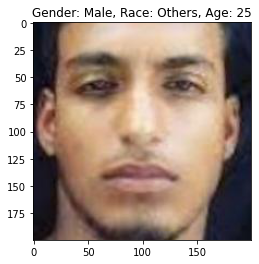

In [ ]:
row = df.iloc[np.random.randint(len(df))]
img = plt.imread(str(data_folder / row["img_name"]))
show_face(img, row["race"], row["gender"], row["age"])

Посмотрим на их распределение:

Counter({'White': 10078, 'Black': 4526, 'Indian': 3975, 'Asian': 3434, 'Others': 1692})
Counter({'Male': 12391, 'Female': 11314})


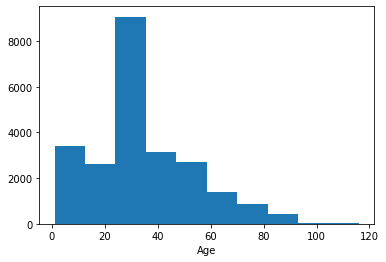

In [ ]:
races_verbose = [race_mapping[int(race)] for race in df["race"]]
genders_verbose = [gender_mapping[int(gender)] for gender in df["gender"]]
from collections import Counter
print(Counter(races_verbose))
print(Counter(genders_verbose))
_ = plt.hist(df["age"]*max_age)
_ = plt.xlabel("Age")

## Создание генератора данных для модели предсказания пола.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_input_facenet(image_):
    """
    image_ -- тензор размера (1, H, W, 3)
    return: картинка, с примененным preprocess_input(..., version=2) из keras_vggface 
    """
    preprocessed = utils.preprocess_input(image_, version=2)
    return preprocessed

image_gen = ImageDataGenerator(preprocessing_function=preprocess_input_facenet)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 128
IMAGE_SIZE = 224

train_generator = image_gen.flow_from_dataframe(df_train, x_col='img_name', y_col='gender', class_mode='binary', directory=str(data_folder), 
                                                batch_size=BATCH_SIZE, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True)


val_generator = image_gen.flow_from_dataframe(df_val, x_col='img_name', y_col='gender', class_mode='binary', directory=str(data_folder), 
                                                batch_size=BATCH_SIZE, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=False)

Found 18946 validated image filenames belonging to 2 classes.
Found 4759 validated image filenames belonging to 2 classes.


Попробуем отобразить картинку и ее лейбл для проверки генерации:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Female


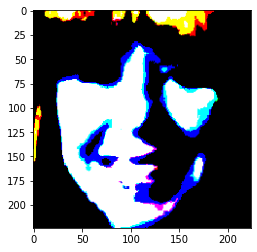

In [ ]:
plt.imshow(sample_images[100])
print(gender_mapping[int(sample_labels[100])])
# мы получим очень странное изображение и это нормально. 
# matplotlib ожидает картинку с интесивностями от 0 до 1 если она типа float и от 0 до 255 если int.

In [ ]:
print(sample_images[100].max(), sample_images[100].min()) # можно увидеть что значения яркостей типа float и в т.ч. отрицательные

107.9088 -126.0912


Чтобы преобразовать картинку, исользуемую keras_vggface, обратно к изображению, которое можно визуализировать с помощью `matplotlib`нам потребуется отдельная функция

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Female


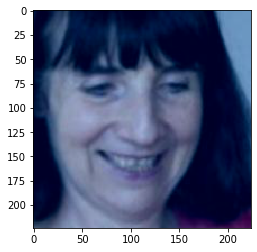

In [ ]:
def deprocess_image(vggface_image):
  
    image = np.copy(vggface_image)
    image = image[..., ::-1]
    image[..., 0] += 91.4953
    image[..., 1] += 103.8827
    image[..., 2] += 131.0912
        
    return image/255

# теперь картинка отображается корректно
plt.imshow(deprocess_image(sample_images[5]))
print(gender_mapping[int(sample_labels[5])])

##Обучение модели предсказания пола


In [ ]:
# отрежем от vggface_model последний слой классификатора 
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____________________________________________________________________________________________

In [ ]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

In [ ]:
print("Количество слоев в базовой модели: ", len(base_model.layers))

Количество слоев в базовой модели:  175


In [ ]:
fine_tune_at = 150
# все слои до fine_tune_at заморозим
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Dense(255, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
from pathlib import Path
path = Path("/content/drive/My Drive/model_gender")
path.mkdir(exist_ok=True, parents=True) 
assert path.exists()
cpt_filename = "checkpoint_best.h5"  
cpt_path =str(path / cpt_filename)

Mounted at /content/drive/


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

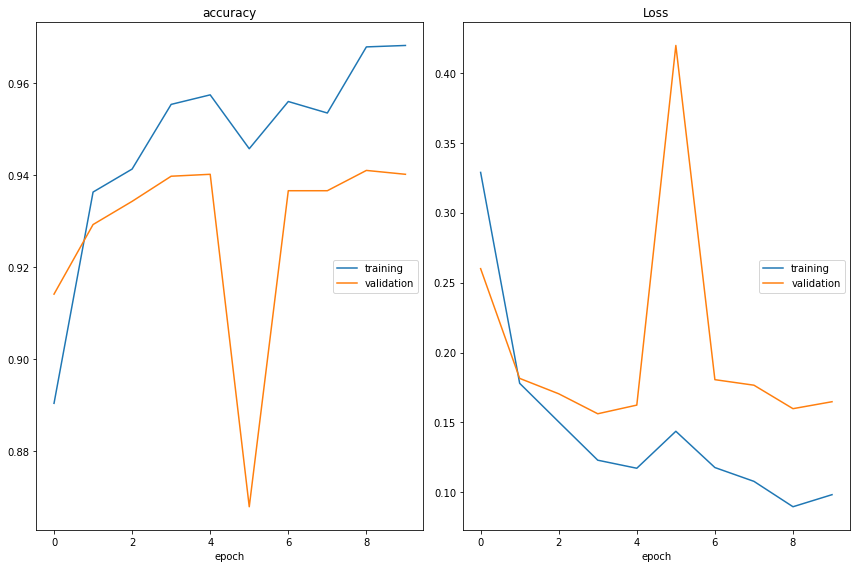

accuracy
	training         	 (min:    0.890, max:    0.968, cur:    0.968)
	validation       	 (min:    0.868, max:    0.941, cur:    0.940)
Loss
	training         	 (min:    0.090, max:    0.329, cur:    0.098)
	validation       	 (min:    0.156, max:    0.420, cur:    0.165)

Epoch 00010: val_accuracy did not improve from 0.94095


In [ ]:
EPOCHS = 10
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=25,
    validation_data=val_generator,
    callbacks=[PlotLossesCallback(), checkpoint])

In [ ]:
def show_faces(images, real_race=None, real_gender=None, real_age=None, 
               predicted_race=None, predicted_gender=None, predicted_age=None):
    plt.figure(figsize=(10,10))
    labels = {"Gender": [predicted_gender, real_gender],
                  "Race": [predicted_race, real_race],
                  "Age": [predicted_age, real_age]}
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(deprocess_image(images[i]))
        real_str = "Real:"
        pred_str = "Pred:"
        correct = True
        for name, (predicted, real) in labels.items():
            if predicted is None:
                continue
            if name == "Age":
                real_age = int(real[i]*int(max_age))
                predicted_age = int(predicted[i]*max_age)
                real_str += f"{real_age}"
                pred_str += f"{predicted_age}"
                if np.abs(predicted_age - real_age) > 6:
                    correct = False

            elif name == "Gender":
                real_gender = int(real[i])
                predicted_gender = int(predicted[i] > 0.5)
                real_str += f"{gender_mapping[real_gender]}, "
                pred_str += f"{gender_mapping[predicted_gender]}, "
                if real_gender != predicted_gender:
                    correct = False
            elif name == "Race":
                real_race = int(real[i])
                predicted_race = np.argmax(predicted[i])
                real_str += f"{race_mapping[real_race]}, "
                pred_str += f"{race_mapping[predicted_race]}, "
                if real_race != predicted_race:
                    correct = False
                
        title_obj = plt.title(f"{real_str}\n{pred_str}")
            
        plt.subplots_adjust(wspace=0.4)
        if not correct:
            plt.setp(title_obj, color='r')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

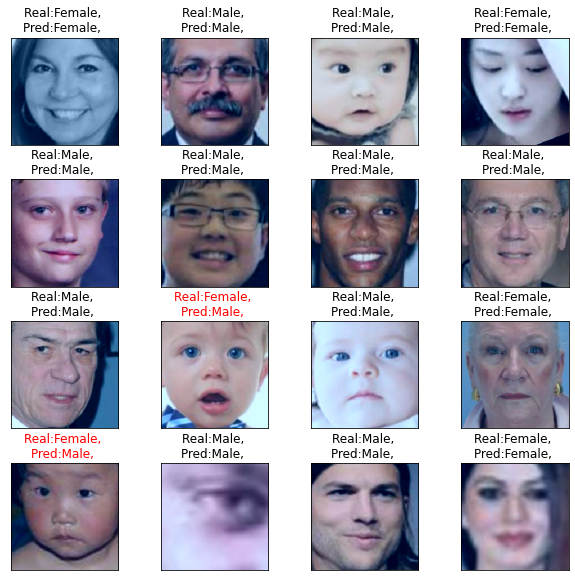

In [ ]:
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model_gender.predict(sample_validation_images)
show_faces(sample_validation_images, real_gender=sample_validation_labels, predicted_gender=predicted)

##Обучение модели предсказания расы


In [ ]:
vggface_model = load_model("resnet50face.h5")
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)

In [ ]:
train_generator = image_gen.flow_from_dataframe(df_train, x_col='img_name', y_col='race', class_mode='sparse', directory=str(data_folder), 
                                                batch_size=BATCH_SIZE, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True)


val_generator = image_gen.flow_from_dataframe(df_val, x_col='img_name', y_col='race', class_mode='sparse', directory=str(data_folder), 
                                                batch_size=BATCH_SIZE, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=False)


Found 18946 validated image filenames belonging to 5 classes.
Found 4759 validated image filenames belonging to 5 classes.


In [ ]:
base_model.trainable = True

fine_tune_at = 150
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Dense(255, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
from pathlib import Path
path = Path("/content/drive/My Drive/model_race")
path.mkdir(exist_ok=True, parents=True) 
assert path.exists()
cpt_filename = "checkpoint_best.h5"  
cpt_path =str(path / cpt_filename)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

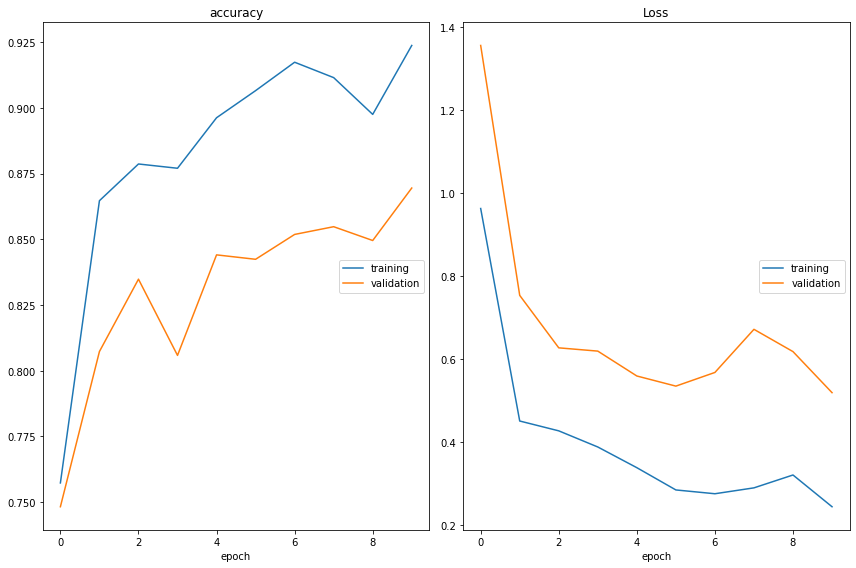

accuracy
	training         	 (min:    0.757, max:    0.924, cur:    0.924)
	validation       	 (min:    0.748, max:    0.870, cur:    0.870)
Loss
	training         	 (min:    0.244, max:    0.962, cur:    0.244)
	validation       	 (min:    0.519, max:    1.355, cur:    0.519)

Epoch 00010: val_accuracy improved from 0.85480 to 0.86951, saving model to /content/drive/My Drive/model_race/checkpoint_best.h5


In [ ]:
EPOCHS = 10
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=25,
    validation_data=val_generator,
    callbacks=[PlotLossesCallback(), checkpoint])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

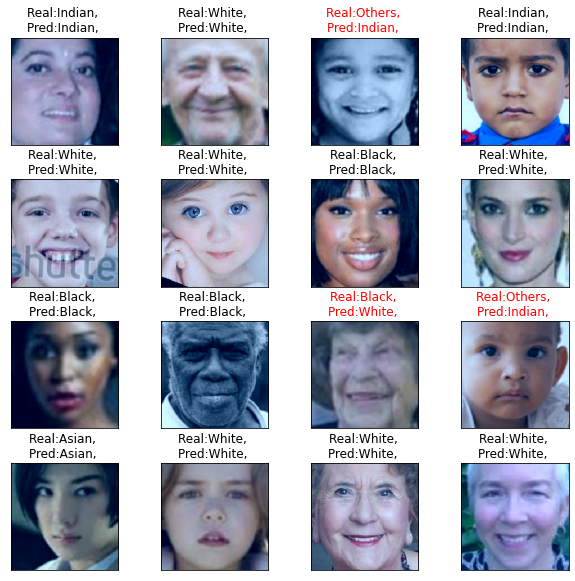

In [ ]:
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model_race.predict(sample_validation_images)
show_faces(sample_validation_images, real_race=sample_validation_labels, predicted_race=predicted)